In [1]:
!pip install tensorflow

In [3]:
# 安装 Kaggle 库
!pip install -q kaggle

# 创建 .kaggle 文件夹
!mkdir -p ~/.kaggle

# 移动 kaggle.json 文件到 .kaggle 文件夹
!cp kaggle.json ~/.kaggle/

# 设置权限
!chmod 600 ~/.kaggle/kaggle.json
# 下载数据集
!kaggle datasets download -d yuzhouzhu/attosecond-streaking-phase-retrieval-data

# 解压数据集
!unzip attosecond-streaking-phase-retrieval-data.zip -d data/
import pandas as pd

# 加载训练数据
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')

# 查看数据
print("finish\n")



Dataset URL: https://www.kaggle.com/datasets/yuzhouzhu/attosecond-streaking-phase-retrieval-data
License(s): CC0-1.0
100% 5.27G/5.29G [00:34<00:00, 176MB/s]
100% 5.29G/5.29G [00:35<00:00, 161MB/s]
Archive:  attosecond-streaking-phase-retrieval-data.zip
  inflating: data/X_train.csv        
  inflating: data/y_train.csv        
finish



In [6]:
import numpy as np
import matplotlib.pyplot as plt



# 划分测试集，假设取最后  的数据
split_ratio = 0.015
num_test_samples = int(len(X_train) * split_ratio)

X_test = X_train[-num_test_samples:]  # 测试集输入
y_test = y_train[-num_test_samples:]  # 测试集输出

# 剩余部分作为新的训练集
X_train = X_train[:-num_test_samples]
y_train = y_train[:-num_test_samples]

print(f"New training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# 保存数据到 CSV 文件
X_train.to_csv('X_train_new.csv', index=False, header=False)
y_train.to_csv('y_train_new.csv', index=False, header=False)
X_test.to_csv('X_test_split.csv', index=False, header=False)
y_test.to_csv('y_test_split.csv', index=False, header=False)


New training set shape: (67916, 17458), (67916, 290)
Test set shape: (1034, 17458), (1034, 290)


In [7]:
# 定义模型构建函数
def build_attosecond_retrieval_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (10, 10), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same'))
    model.add(layers.Conv2D(64, (10, 10), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same'))
    model.add(layers.Conv2D(128, (10, 10), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', strides=(2, 2), padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(290))  # 输出XUV和IR谱的复数部分
    return model

In [8]:
# 加载训练数据
X_csv_filename = "/content/X_train_new.csv"
y_csv_filename = "/content/y_train_new.csv"

# 检查文件是否存在
if not os.path.exists(X_csv_filename) or not os.path.exists(y_csv_filename):
    print("训练数据文件不存在，请确保已生成并上传到指定路径。")
else:
    # 加载 X_train
    X_train = np.loadtxt(X_csv_filename, delimiter=",")
    print("X_train shape before reshaping:", X_train.shape)  # (69999, 17458)

    # 加载 y_train
    y_train = np.loadtxt(y_csv_filename, delimiter=",")
    print("y_train shape:", y_train.shape)  # (69999, 290)

    # 重塑 X_train
    X_train = X_train.reshape(-1, 301, 58, 1)
    print("X_train shape after reshaping:", X_train.shape)  # (69999, 301, 58, 1)

    # 转换数据类型
    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')

    # 构建和编译模型
    input_shape = (301, 58, 1)
    model = build_attosecond_retrieval_model(input_shape)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse')

    # 打印模型摘要
    model.summary()

    # 训练模型
    batch_size = 10
    epochs = 70
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    # 保存模型
    model.save('/content/drive/MyDrive/attosecond_model.h5')


X_train shape before reshaping: (67916, 17458)
y_train shape: (67916, 290)
X_train shape after reshaping: (67916, 301, 58, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 301, 58, 32)         │           3,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 301, 58, 32)         │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 301, 58, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 151, 29, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 151, 29, 64)         │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 151, 29, 64)         │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 151, 29, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 76, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 76, 15, 128)         │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 76, 15, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 76, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 38, 8, 128)          │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 38912)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      39,846,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 290)                 │         297,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,096,930 (160.59 MB)

 Trainable params: 42,096,930 (160.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
6113/6113 ━━━━━━━━━━━━━━━━━━━━ 91s 12ms/step - loss: 0.1064 - val_loss: 0.0489
Epoch 2/70
6113/6113 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 0.0444 - val_loss: 0.0530
Epoch 3/70
6113/6113 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 0.0289 - val_loss: 0.0212
Epoch 4/70
6113/6113 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 0.0209 - val_loss: 0.0191
Epoch 5/70
6113/6113 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 6/70
6113/6113 ━━━━━━━━━━━━━━━━━━━━ 63s 10ms/step - loss: 0.0144 - val_loss: 0.0113
Epoch 7/70
6113/6113 ━━━━━━━━━━━━━━━━━━━━ 63s 10ms/step - loss: 0.0125 - val_loss: 0.0134
Epoch 8/70
6113/6113 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 0.0115 - val_loss: 0.0134
Epoch 9/70
6113/6113 ━━━━━━━━━━━━━━━━━━━━ 63s 10ms/step - loss: 0.0103 - val_loss: 0.0083
Epoch 10/70
6113/6113 ━━━━━━━━━━━━━━━━━━━━ 64s 10ms/step - loss: 0.0100 - val_loss: 0.0086
Epoch 11/70
6113/6113 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 12

In [10]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test):
    """
    计算模型的评估指标，包括 MSE、MAE、R² 和 RMSE。
    """
    # 调整 X_test 的形状以匹配模型输入
    X_test = X_test.values.reshape(-1, 301, 58, 1)  # 假设每个样本是 (301, 58)

    # 模型预测
    y_pred = model.predict(X_test)

    # 计算指标
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    print("Model Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 调用评估函数
evaluate_model(model, X_test, y_test)


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
Model Evaluation Metrics:
Mean Squared Error (MSE): 0.0103
Mean Absolute Error (MAE): 0.0539
R² Score: -159938.8438
Root Mean Squared Error (RMSE): 0.1017


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


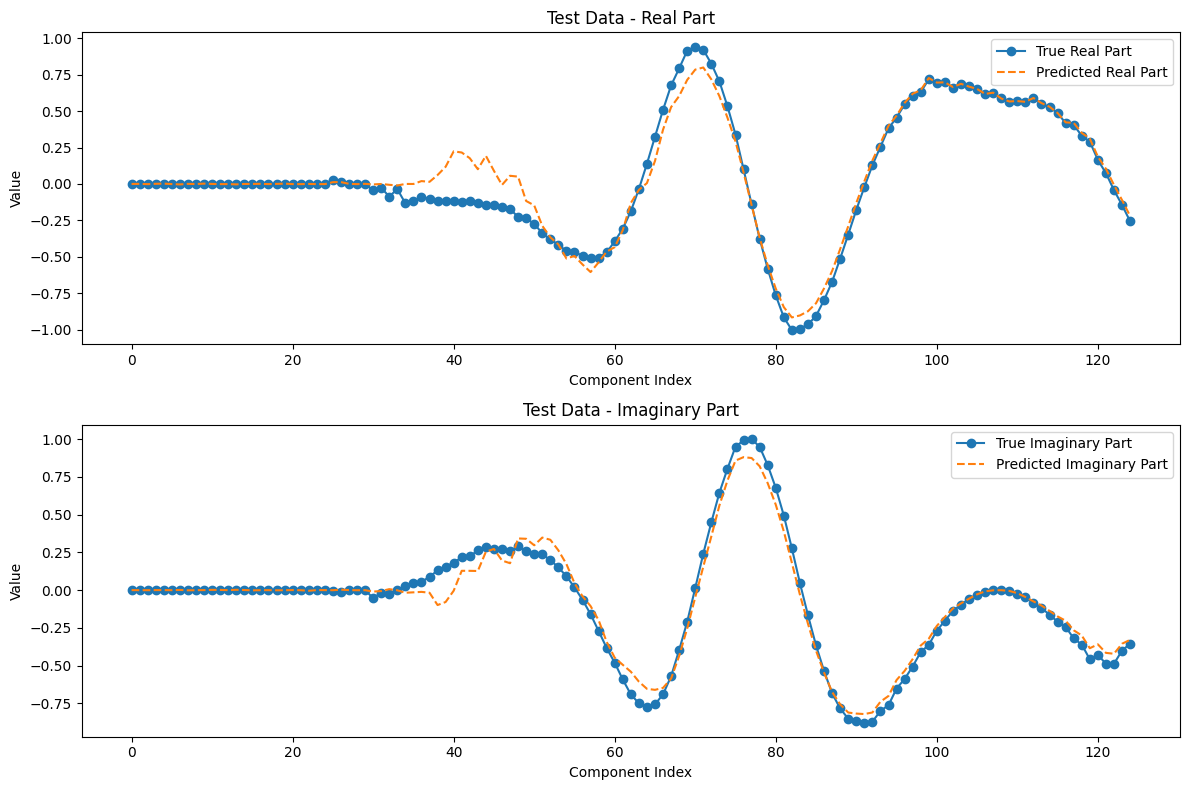

In [12]:
import matplotlib.pyplot as plt

def visualize_predictions(y_test, y_pred, title="Prediction vs Ground Truth"):
    """
    可视化真实值和预测值的对比，包括 Real Part 和 Imaginary Part。
    """
    # 确保 y_test 和 y_pred 转换为 Numpy 数组
    y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test
    y_pred = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else y_pred

    # 真实值的实部和虚部
    y_test_real = y_test[:, :125]
    y_test_imag = y_test[:, 125:250]

    # 预测值的实部和虚部
    y_pred_real = y_pred[:, :125]
    y_pred_imag = y_pred[:, 125:250]

    # 选择一个样本进行可视化
    sample_index = 0

    plt.figure(figsize=(12, 8))

    # 实部对比
    plt.subplot(2, 1, 1)
    plt.plot(y_test_real[sample_index], label="True Real Part", marker="o")
    plt.plot(y_pred_real[sample_index], label="Predicted Real Part", linestyle="--")
    plt.title(f"{title} - Real Part")
    plt.xlabel("Component Index")
    plt.ylabel("Value")
    plt.legend()

    # 虚部对比
    plt.subplot(2, 1, 2)
    plt.plot(y_test_imag[sample_index], label="True Imaginary Part", marker="o")
    plt.plot(y_pred_imag[sample_index], label="Predicted Imaginary Part", linestyle="--")
    plt.title(f"{title} - Imaginary Part")
    plt.xlabel("Component Index")
    plt.ylabel("Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

# 调整 X_test 的形状以适配模型
X_test_reshaped = X_test.values.reshape(-1, 301, 58, 1)

# 模型预测
y_pred = model.predict(X_test_reshaped)

# 可视化结果
visualize_predictions(y_test, y_pred, title="Test Data")
